In [1]:
%load_ext autoreload 
%autoreload 2
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import numpy.linalg as la

import scipy.linalg
import scipy.stats

import mdpy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction to mdpy

If you're reading this notebook, I am forced to assume that you're interested in Markov chains, Markov Decision Processes, and perhaps even in reinforcement learning.

If not, maybe come back after a trip to [the appropriate Wikipedia page](https://en.wikipedia.org/wiki/Markov_chain)?

I wrote `mdpy` to encapsulate some of the code I found myself rewriting when analyzing MDPs.
Most of the time, AI researchers model an environment as an MDP, but then avoid actually taking advantage of the available math.
For example, when analyzing a new environment, they estimate the value function of a polciy by running a tremendous number of simulations.
But if your environment is discrete and Markovian, it's *straightforward to solve for the value function analytically*.

So you not only get the exact results, but you get them *faster*, which allows for things like generating random MDPs to test algorithms with, testing algorithms with more confidence, etc.

So what follows is a demonstration of some of the things `mdpy` can do.

## Define a Markov process

We first define a Markov process (also referred to as a Markov chain).
Markov chains are the results of applying a policy to an MDP.

We require a transition matrix, $P$, and an expected reward matrix, $R$.
$P_{ij}$ defines the probability of transitioning from state $i$ to state $j$, while $R_{ij}$ defines the expected reward from such a transition.

In [2]:
# transition matrix
P = np.array([
    [0.0, 0.5, 0.5, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, 0.9, 0.1],
    [1.0, 0.0, 0.0, 0.0, 0.0]
])

# expected reward matrix
R = np.array([
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0],
    [0.0, 0.0, 0.0, -1 , 0.0],
    [0.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 0.0, 0.0, 0.0, 0.0]
])

# number of states
ns = len(P)

# expected reward vector
rvec = (P*R) @ np.ones(ns)

Exciting stuff.
The MC defined above has a fairly simple structure:

- Starting from State 0, there are two possible transitions (to State 1 and State 2) 
- Both State 1 and State 2 transition to State 3
- State 3 tends to transition to itself but may also transition to State 4.
- State 4 always goes to State 0, and we're back to the start.

### Matrix Properties

There are a few ways to look at MDPs/MCs strictly from the matrices which define them.
In fact, it turns out that there's a group of people calling themselves "mathematicians" who seem to delight in coming up with new ways to these structures.

As such, I've implemented a handful in `mdpy`.

In [3]:
# Define a function encapsulating the matrix-related functions
def matrix_properties(mat):
    funcs = [
        mdpy.is_aperiodic,
        mdpy.is_diagonal,
        mdpy.is_ergodic,
        mdpy.is_matrix,
        mdpy.is_nonnegative,
        mdpy.is_periodic,
        mdpy.is_reducible,
        mdpy.is_square,
        mdpy.is_stochastic,
        mdpy.is_substochastic,
    ]
    return {f.__name__: f(mat) for f in funcs} 

In [4]:
# Let's use this to check what properties P has
prop_dct = matrix_properties(P)
for prop, value in prop_dct.items():
    print("{!s:<20s} {!s:<20}".format(prop, value))

is_aperiodic         True                
is_stochastic        True                
is_nonnegative       True                
is_ergodic           True                
is_matrix            True                
is_reducible         False               
is_periodic          False               
is_diagonal          False               
is_substochastic     True                
is_square            True                


Some brief explanation:

A transition matrix describes probabilities of moving between states, so it should be **square**.
Since this isn't quantum mechanics, negative probabilities make no sense, so it should be **non-negative**.
As it is, the probabilities of each row should sum to one (making it a **stochastic** matrix).

To be the transition matrix of a true Markov chain, we need two slightly more complicated properties:
the matrix must **aperiodic** and **irreducible**.
To be aperiodic, we require that the chain can't leave a state and then return to it only in multiples of $n$ steps, with $n > 1$.
In order to be irreducible the chain can't get "cut off" from other states-- there should always be a sequence of possible transitions taking it from state $i$ to state $j$ for *every* $i$ and $j$.

------

There are some other things we might wish to learn about our transition matrix.

The stationary distribution is one such thing.

It is defined as the left eigenvector with eigenvalue one.
Provided we have a real Markov process on our hands (i.e., it's irreducible and aperiodic) then there is only one such eigenvector.

It's probably better understood as the long-term probability distribution the Markov chain evolves towards.
For example, if we let it run for a long time and then came back and peeked at the current state, what state would it be in?
Obviously we can't know for sure (unless there's a terminal state, but again, we assume it's irreducible and aperiodic), so we instead get probabilities for each state.

In [5]:
d_pi = mdpy.stationary(P)

### Visualization

We can also use tools like `networkx` or `graphviz` to visualize the structure of the transition matrix

In [6]:
def draw_graph(mat, method='draw_spring', **kwargs):
    """Slightly customized networkx graph drawing."""
    graph = nx.DiGraph(mat)
    edge_weights = [0.5 + i[-1] for i in graph.edges(data='weight')]
    
    # Graph drawing options
    options = {
        'edge_cmap': mpl.cm.viridis,
        'node_size': 500,
        'width': edge_weights,
        'with_labels':True,
        **kwargs
    }
    
    draw_func = getattr(nx, method)
    return draw_func(graph, **options)

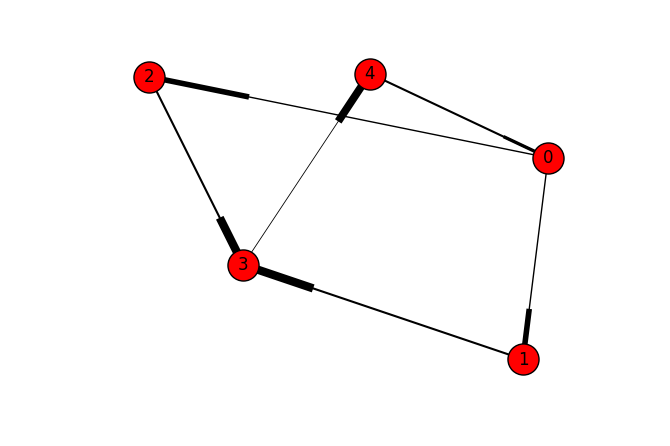

In [7]:
# print([i for i in dir(nx) if i.startswith('draw')]) # some available methods
draw_graph(P, method='draw_spring')

## Solving MDPs

So to get a "real" Markov Decision Process, you need a discount factor, denoted "γ", which defines how much you should discount the reward from a subsequent state.
If you care about all future rewards equally, γ should be 1; if you care only about the short-term rewards, γ should be close to zero.

One can think about this in a number of ways-- prioritizing immediate rewards might reflect the time-value of money in a financial setting, or the growing uncertainty of the model in a robotics application, or it might encode the fact that the experiment could end at any time (with probability `γ-1`).

It is possible to have state-dependent discounting (which leads to the topic of GVFs), but we can put that aside for a moment.

In [8]:
gm = 0.9 # it could be a vector or diagonal matrix for state-dependent γ
v_pi = mdpy.mc_return(P, rvec, gm)
print(v_pi)

[ 6.4466597   8.16295522  6.16295522  7.95883913  6.80199373]


----

**Author's Note: I got bored, so I'm abandoning the pedagogical tone and just going to show the code for the rest of this notebook**

------


### Least-Squares Approximation

In [9]:
# Random features
X = np.random.binomial(1, 0.3, size=(ns, ns+1))

# Identity matrix
I = np.eye(ns)

# If rank == number of states in MDP, we can represent values exactly
# anything less ==> we can only approximate.
np.linalg.matrix_rank(X)

4

In [10]:
X

array([[0, 1, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0, 1]])

In [11]:
v_ls = mdpy.ls_values(P, rvec, gm, X)
print(v_ls)

[ 6.4466597   8.16295522  6.16295522  0.          6.80199373]


### Temporal Difference Learning Fixed Point

In [12]:
lm = 0.0

In [13]:
v_td = mdpy.td_values(P, rvec, gm, lm, X)

In [14]:
print(v_td)

[  4.99600361e-16   1.00000000e+00  -1.00000000e+00   0.00000000e+00
   1.00000000e+00]


In [15]:
def mse(a, b):
    return np.mean((a - b)**2)

def weighted_sqerr_factory(P, ivec=None):
    if ivec is None:
        ivec = 1
    __di = mdpy.stationary(P)*ivec
    __di = __di/np.sum(__di) # normalize
    def _msve(a, b):
        return np.sum(__di*(a-b)**2)
    return __msve

In [16]:
print(mse(v_pi, v_ls))
print(mse(v_pi, v_td))
print(mse(v_td, v_ls))

12.6686240753
48.2363055803
35.567681505


In [17]:
G_td = mdpy.lambda_return(P, rvec, gm, lm, v_td)

In [18]:
G_ls = mdpy.lambda_return(P, rvec, gm, lm, v_ls)

In [19]:
# should be the same as the 'true' return
mdpy.lambda_return(P, rvec, gm, lm, v_pi)

array([ 6.4466597 ,  8.16295522,  6.16295522,  7.95883913,  6.80199373])

In [20]:
# close, but no logner the same objective!
mse(G_td, v_pi)

45.280625282815919

## Variance and Second Moment

In [21]:
# variance of the return
mdpy.sobel_variance(P, R, gm)

array([ 2.04220828,  1.52124479,  1.52124479,  1.87807999,  1.65418871])

In [22]:
mdpy.second_moment(P, R, gm)

array([ 43.60162956,  68.15508274,  39.50326185,  65.22120036,  47.9213074 ])

In [23]:
mdpy.second_moment(P, R, gm) - v_pi**2

array([ 2.04220828,  1.52124479,  1.52124479,  1.87807999,  1.65418871])

In [24]:
mdpy.lambda_second_moment(P, R, gm, lm, v_pi) - v_pi**2

array([  8.10000000e-01,   2.84217094e-14,   7.81597009e-14,
         3.74970391e-01,   0.00000000e+00])